In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
image_size = 350
batch_size = 16
save_model_filename = 'effnet_(1).h5'

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_path = '../input/cassava-leaf-disease-classification/train_images'

In [4]:
def image_path(image):
    return os.path.join(train_path,image)

train['image_id'] = train['image_id'].apply(image_path)

In [5]:
train['label'] = train['label'].astype('str')

In [6]:
image_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                                horizontal_flip=True, vertical_flip=True, fill_mode='nearest', brightness_range=[0.7, 1.3],
                                rotation_range=270, zoom_range=0.2, shear_range=10, width_shift_range=0.2, height_shift_range=0.2,
                                validation_split=0.2, rescale = 1./255)

test_gen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = image_gen.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                subset='training', batch_size=batch_size, seed=1,
                                                shuffle=True, class_mode='categorical', target_size=(image_size,image_size))

validation_generator = image_gen.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                   subset='validation', batch_size=batch_size, seed=1,
                                                   shuffle=False, class_mode='categorical', target_size=(image_size,image_size))

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [8]:
def build_efficientnet_b3():
    model = Sequential()
    model.add(EfficientNetB3(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [9]:
model = build_efficientnet_b3()
model.summary()

2022-05-08 04:14:31.362143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 04:14:31.496759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 04:14:31.497538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 04:14:31.499300: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 11, 11, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_________________________________________________________________


In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(save_model_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=2, min_lr=0, verbose=1)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


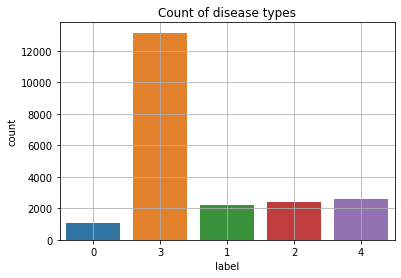

In [12]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of disease types')
plt.grid()
plt.show()

In [13]:
epoch = 30

history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

2022-05-08 04:14:38.929100: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-08 04:14:52.735280: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1070/1070 [==============================] - 1090s 1s/step - loss: 0.7489 - accuracy: 0.7384 - val_loss: 2.2052 - val_accuracy: 0.2386

Epoch 00001: val_loss improved from inf to 2.20519, saving model to effnet_(1).h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
1070/1070 [==============================] - 983s 918ms/step - loss: 0.5888 - accuracy: 0.7972 - val_loss: 1.8063 - val_accuracy: 0.1192

Epoch 00002: val_loss improved from 2.20519 to 1.80627, saving model to effnet_(1).h5
Epoch 3/30
1070/1070 [==============================] - 992s 927ms/step - loss: 0.5477 - accuracy: 0.8148 - val_loss: 44.1154 - val_accuracy: 0.3966

Epoch 00003: val_loss did not improve from 1.80627
Epoch 4/30
1070/1070 [==============================] - 983s 918ms/step - loss: 0.5282 - accuracy: 0.8229 - val_loss: 3.5612 - val_accuracy: 0.1192

Epoch 00004: val_loss did not improve from 1.80627

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/30
1070/1070 [==============================] - 993s 928ms/step - loss: 0.4270 - accuracy: 0.8567 - val_loss: 0.8269 - val_accuracy: 0.7357

Epoch 00005: val_loss improved from 1.80627 to 0.82687, saving model to effnet_(1).h5
Epoch 6/30
1070/1070 [=========================

train loss: 0.31560423970222473
train accuracy: 0.891167163848877
dev loss: 0.37000930309295654
dev accuracy: 0.8756718635559082


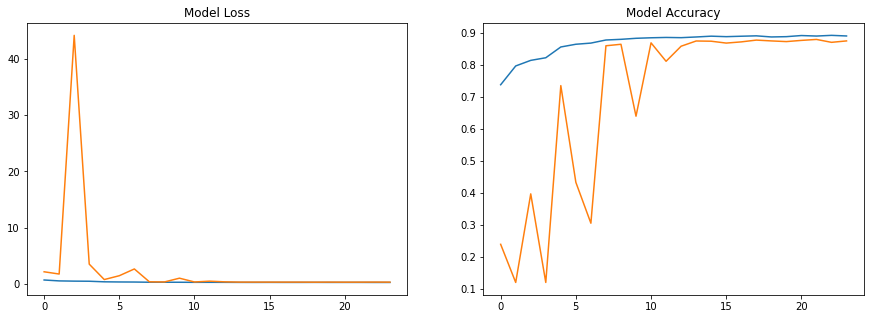

In [14]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

results = pd.DataFrame(history.history)

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(results[['loss', 'val_loss']])
axs[0].set_title('Model Loss')

axs[1].plot(results[['accuracy', 'val_accuracy']])
axs[1].set_title('Model Accuracy')

plt.show()

In [15]:
pred = model.predict(validation_generator)
predictions = np.argmax(pred, axis=1)
actual = validation_generator.classes

from sklearn.metrics import classification_report

report = classification_report(actual, predictions, target_names=['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy'])
print(report)

              precision    recall  f1-score   support

         CBB       0.58      0.68      0.62       200
        CBSD       0.81      0.75      0.78       436
         CGM       0.83      0.78      0.80       495
         CMD       0.95      0.96      0.96      2638
     Healthy       0.71      0.71      0.71       510

    accuracy                           0.88      4279
   macro avg       0.78      0.78      0.78      4279
weighted avg       0.88      0.88      0.88      4279



In [16]:
test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

In [17]:
test_path = '../input/cassava-leaf-disease-classification/test_images'

def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)

test['label'] = test['label'].astype('str')

In [18]:
test_generator = test_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=applications.efficientnet.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

Found 1 validated image filenames belonging to 1 classes.


In [19]:
output = model.predict(test_generator)

In [20]:
submission = pd.DataFrame()
submission['image_id'] = list(os.listdir(test_path))
submission['label'] = np.argmax(output, axis=1)
submission.to_csv("submission.csv", index=False)

In [21]:
submission.head()

,image_id,label
0,2216849948.jpg,2


In [22]:
model.save('model_final.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
